# Word2vec only with one matrix

Choose CBOW/Skip-Gram again. Implement it, but now without second `h_dim x vocab_size` matrix. Remember what was the loss function in Stanford lecture.

$$ L = - \frac{1}{T} \sum_{t=1}^T \sum_{-m <= j <= m, j \ne 0} log P(w_{t}|w_{t+j})$$


$$ P(w_i | w_h) = \frac{exp(s(v_i, v_h))}{\sum exp(s(v_i, v_w))}$$

Where $s(x, y)$ is a similarity function. It is common to use dot-product here $s(x, y) = s^Ty$. The sum in the denominator is across all vocabulary for $P$ to be a probability distribution.

Look to this formula closer. There is no projection back to vocabulary dimension in the loss! So, we can reduce the number of parameters by the factor of two by not using the second matrix $W'$. Your new task is to code CBOW / SkipGram with this loss.

**Main idea:**

We project word vectors to some space. Next, we work with the space itself. We update projection matrix weights so that similar (in the terms of Distributional semantics) words have similar vectors in that space. We don't need to solve classification task explicitly here.

**Tip:**

Work with matrix operations and not with nn.layers / keras.layers.

**Results of this task** (the very same as in task 3):
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies


**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)



Supplementary materials:
  * [cs224n winter 2017 lecture 2 video](https://www.youtube.com/watch?v=ERibwqs9p38&list=PL3FW7Lu3i5Jsnh1rnUwq_TcylNr7EkRe6&index=2)
  * [cs224n winter 2019 lecture 1 slides](http://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture01-wordvecs1.pdf)

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from collections import Counter
import itertools
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

In [5]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [0]:
class CBOWBatcher:
    def __init__(self, words):
        self.words = words
        self.vocab_size = len(words)
        self.remaining_words = self.words
    
        self.index_words = []
        self.word2index = dict()
        self.index2word = dict()
        self.window_size = 0
        
    def delete_rare_words(self, min_frequency = 9):
        words_count = Counter(self.words)
        
        sorted_words_count = sorted(words_count.items(), key=lambda pair: pair[1], reverse=True)

        # choose words with frequency > min_frequency
        mask = list(map(lambda x: x[1] > min_frequency, sorted_words_count))
        sorted_words_count = np.array(sorted_words_count)[mask]

        # add __unk__
        remaining_words = list(map(lambda x: x[0], sorted_words_count))
        remaining_words.append("__unk__")
        self.remaining_words = remaining_words
        self.vocab_size = len(remaining_words)
    
    def create_indexing(self):
        # numericalization
        numbers = np.arange(len(self.remaining_words))

        self.word2index = dict(zip(self.remaining_words, numbers))
        self.index2word = dict(zip(numbers, self.remaining_words))
        # __unk__
        for word in self.words:
            if word in self.word2index:
                self.index_words.append(self.word2index[word])
            else:
                self.index_words.append(self.word2index["__unk__"])
        
    def CBOW(self, window_size = 2):
        self.window_size = window_size
        x_batch = []
        labels_batch = []
        
        for i in np.arange(window_size, len(self.index_words) - window_size):
            labels_batch.append(self.index_words[i])
            temp_list = self.index_words[i - window_size: i] + self.index_words[i+1: i+window_size+1]
            x_batch.append(temp_list)
        return x_batch, labels_batch
    
    def indices_to_words(self, batch):
        words_batch = []
        shape = np.array(batch).shape
        batch_flatten = np.array(batch).flatten()
        
        for i in batch_flatten:
            if i in self.index2word:
                words_batch.append(self.index2word[i])
            else:
                raise Exception("Incorrect numericalization: {} in {}".format(i, batch))
                
        words_batch = np.array(words_batch).reshape(shape)
        return words_batch

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
text_file = open("/content/drive/My Drive/text8", "r")
words = text_file.read().split(' ')
test = words[:20000]

batcher = CBOWBatcher(test)
batcher.delete_rare_words(3)
batcher.create_indexing()
y = batcher.CBOW()

In [0]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=torch.float32) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

In [0]:
def CBOW(context, w):
    x = context.sum(dim = 0, dtype = torch.float32)
    x = x.reshape((-1, 1))
    x = torch.mm(w, x)
    x = x.reshape((1, -1))
    x = torch.mm(x, w)
    return x


def test_CBOW(w):
    x = torch.tensor([[0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 0]], dtype = torch.float32)
    x = x.to(device=device, dtype=torch.float32)
    scores = CBOW(x, w)
    print(scores)
    
#test_CBOW(w)

In [0]:
def oneHot_generate(batches, labels, vocab_size):
    for batch, label in zip(batches, labels):
        batch = np.array(batch)
        oneHot_batch = np.zeros((batch.shape[0], vocab_size))
        oneHot_batch[np.arange(batch.shape[0]), batch] = 1

        oneHot_label = np.zeros((vocab_size))
        oneHot_label[label] = 1
        yield (oneHot_batch, label)

In [0]:
def train(w, lr, contexts, labels, epochs=1):
    
    loss_list = []
    for e in range(epochs):
        for t, (context, label) in enumerate(oneHot_generate(contexts, labels, batcher.vocab_size)):
          

            x = torch.tensor(context, dtype=torch.float32) 
            y = torch.tensor([label], dtype=torch.float32)
            
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.float32)

            scores = CBOW(x, w)
            cw = torch.mm(x, scores.reshape((-1, 1)))
            loss = -cw.sum() + 2*batcher.window_size*scores.exp().sum().log()

            loss.backward()
            
            with torch.no_grad():
                w -= lr * w.grad
                w.grad.zero_()
         
        loss_list.append(loss.item())

        if e % 5 == 0:
            print('Epochs %d, loss = %.4f' % (e, loss.item()))
            print()
    return loss_list

In [219]:
hidden_size = 16
w = random_weight((hidden_size, batcher.vocab_size))

start = time.perf_counter()
lr = 0.001
loss_list = train(w, lr, y[0], y[1], epochs=110)
print("Time = ", time.perf_counter() - start)

Epochs 0, loss = 2.7011

Epochs 5, loss = 2.6655

Epochs 10, loss = 2.6383

Epochs 15, loss = 2.6038

Epochs 20, loss = 2.5742

Epochs 25, loss = 2.5507

Epochs 30, loss = 2.5323

Epochs 35, loss = 2.5181

Epochs 40, loss = 2.5070

Epochs 45, loss = 2.4979

Epochs 50, loss = 2.4903

Epochs 55, loss = 2.4843

Epochs 60, loss = 2.4798

Epochs 65, loss = 2.4767

Epochs 70, loss = 2.4750

Epochs 75, loss = 2.4742

Epochs 80, loss = 2.4743

Epochs 85, loss = 2.4748

Epochs 90, loss = 2.4757

Epochs 95, loss = 2.4768

Epochs 100, loss = 2.4779

Epochs 105, loss = 2.4790

Time =  1471.9854016460013


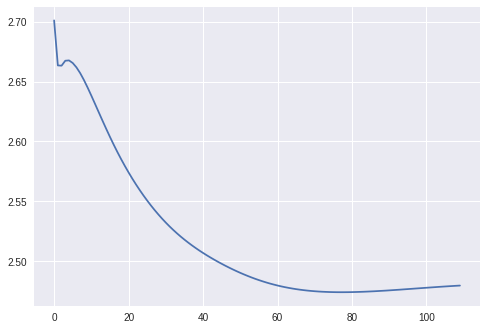

In [220]:
plt.plot(loss_list)
plt.show()

Loss has converged. Time: 24 min on 20000 words

Map token to corresponding word vector:

In [0]:
w = w.detach().numpy().T

In [0]:
def index2vector(word_index):
    return w[word_index]

In [0]:
def word2vector(word):
    return w[batcher.word2index[word]]

### Visualization:

In [0]:
def reduce_to_k_dim(M, k=2):
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    
    svd = TruncatedSVD(n_components = k, n_iter = n_iters, random_state=42)
    M_reduced = svd.fit_transform(M)
    
    return M_reduced

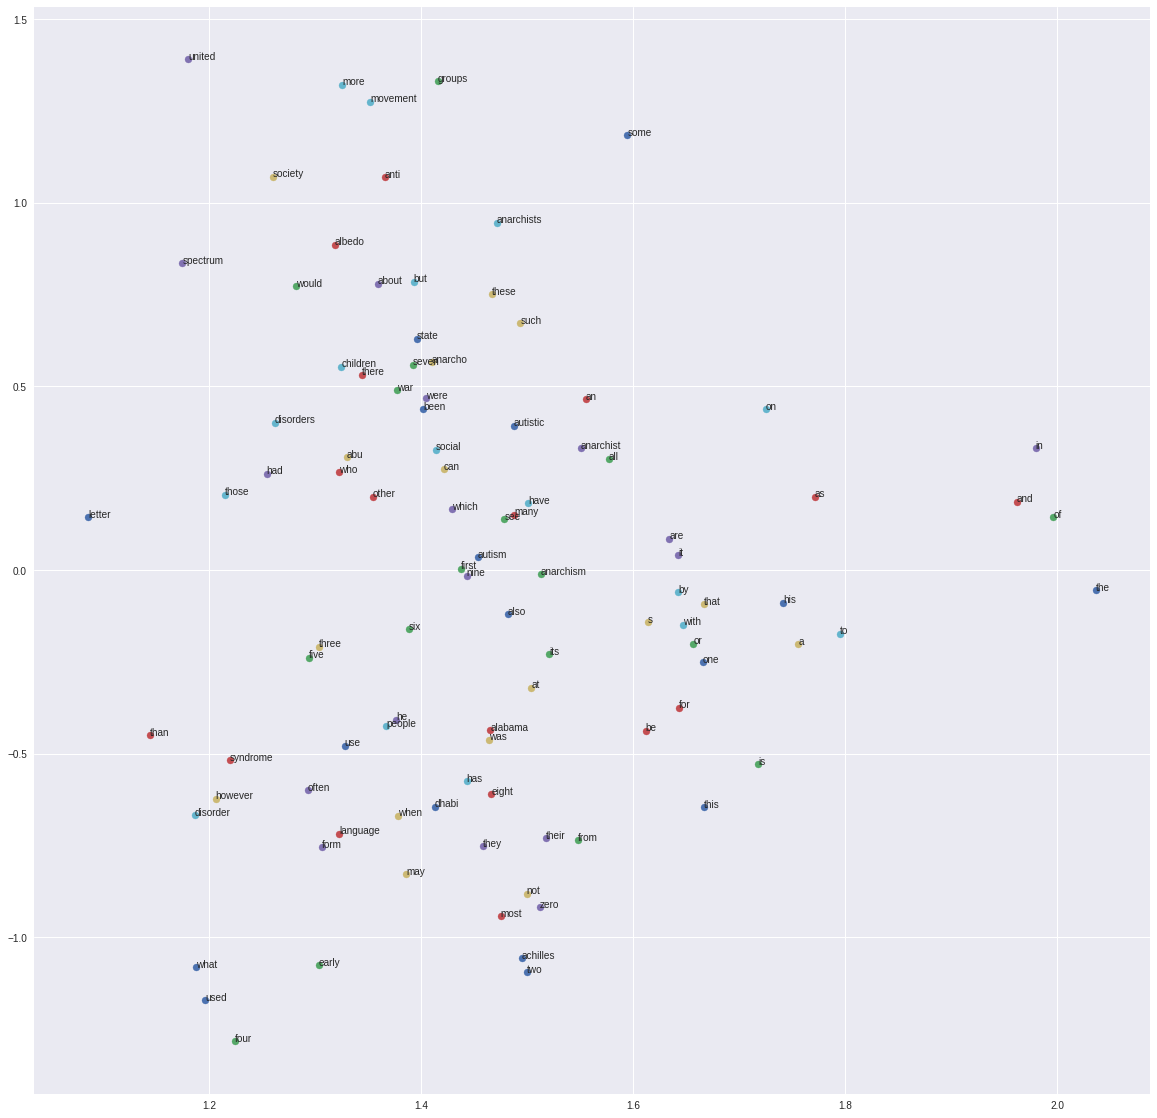

In [238]:
plt.figure(figsize = (20, 20))
w_reduced = reduce_to_k_dim(w)
x_list = w_reduced.T[0, :100]
y_list = w_reduced.T[1, :100]
word_list = np.array(batcher.remaining_words)
for x_, y_, word in zip(x_list, y_list, word_list):
    plt.scatter(x_, y_)
    plt.text(x_, y_, word, fontsize=10)
    
plt.show()

We can see, that numbers are on the left, but maybe it needs more time or more data to learn for a better result.

Qualitative evaluations of word vectors: 

In [0]:
def similar_words(word_index, quantity = 10):
    similarity = []
    
    word_v = index2vector(word_index)
    for i in range(batcher.vocab_size):
        if i != word_index:
            curr_v = index2vector(i)
            sim = word_v@curr_v
            norm = np.sqrt(word_v@word_v)*np.sqrt(curr_v@curr_v)
            similarity.append((i, sim/norm))
    similarity = sorted(similarity, key=lambda pair: pair[1], reverse=True)[:quantity]
    
    return similarity
    

#### Nearest neighbors:

In [99]:
teacher  438, student  207, child 88

NameError: ignored

In [0]:
them, they, she, her
good, true
small, large, human, civilization
spanish
spain

uk
english

european
europe

In [253]:
word = batcher.word2index["one"]

similarity = similar_words(word)
print("Word: ", batcher.index2word[word])
print("Similar words: ")
for sim_word in similarity:
    print(batcher.index2word[sim_word[0]], sim_word[1])

Word:  one
Similar words: 
zero 0.7050459
eight 0.7004265
nine 0.69833976
__unk__ 0.64744705
six 0.63237727
labour 0.62494844
on 0.6177452
seven 0.6126433
may 0.59452695
leo 0.5934515


In [242]:
word = batcher.word2index["zero"]

similarity = similar_words(word)
print("Word: ", batcher.index2word[word])
print("Similar words: ")
for sim_word in similarity:
    print(batcher.index2word[sim_word[0]], sim_word[1])

Word:  zero
Similar words: 
one 0.7050459
th 0.6836101
two 0.6736223
__unk__ 0.67055064
six 0.64962256
alabama 0.64432836
a 0.6348031
three 0.6318677
continued 0.6313837
seven 0.6306365


Quite good at predicting similar words

#### Word analogies:

In [0]:
  def analogy(positive_words, negative_words, quantity = 10):
    res_v = np.zeros(shape = index2vector(0).shape)
    for word in positive_words:
        res_v += word2vector(word)
        
    for word in negative_words:
        res_v -= word2vector(word)
        
    similarity = []
    
    for i in range(batcher.vocab_size):
        curr_v = index2vector(i)
        sim = res_v@curr_v
        norm = np.sqrt(res_v@res_v)*np.sqrt(curr_v@curr_v)
        similarity.append((i, sim/norm))
    similarity = sorted(similarity, key=lambda pair: pair[1], reverse=True)[:quantity]
    
    return similarity

In [267]:
positive_words = ["people", "child"]
negative_words = ["children"]
similarity = analogy(positive_words, negative_words)
for sim_word in similarity:
    print(batcher.index2word[sim_word[0]], sim_word[1])

act 0.7626856485839568
violent 0.7209825804907567
child 0.6805637957765627
system 0.6542200631838346
thought 0.6521875917473545
article 0.6502539288980677
external 0.6441002734807457
due 0.6352613741557995
arab 0.6267685918900445
people 0.5949899291398114


child children

people human

Unfortunately, the model has not learned to find analogies. It would be better if we trained in on the bigger corpus.